<a href="https://colab.research.google.com/github/cerebraters/predict_V2/blob/main/TESTpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!wget https://raw.githubusercontent.com/cerebraters/predict_V2/refs/heads/main/ai.json
!wget https://raw.githubusercontent.com/cerebraters/predict_V2/refs/heads/main/output.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00
--2025-06-30 00:53:51--  https://raw.githubusercontent.com/cerebraters/predict_V2/refs/heads/main/ai.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26197605 (25M) [text/plain]
Saving to: ‘ai.json’

ai.json             100%[===================>]  24.98M   122MB/s    in 0.2s    

2025-06-30 00:53:52 (122 MB/s) - ‘ai.json’ saved [26197605/26197605]

--2025-06-30 00:53:52--  https://raw.githubusercontent.com/cerebraters/predict_V2/refs/heads/main/output.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.


In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import json
from datetime import datetime, timedelta
import joblib
import os
import sys
import warnings
from collections import defaultdict, Counter
from typing import List, Dict, Any, Optional, Union, Tuple
from functools import lru_cache
import heapq
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [12]:
class ItemPredictor:
    def __init__(self, min_cycles: int = 2, period_days: int = 60, top_k: int = 3,
                 recent_weight: float = 3.0, decay_factor: float = 0.95,
                 diversity_factor: float = 0.2, popularity_penalty: float = 0.7):
        self.min_cycles = min_cycles
        self.period_days = period_days
        self.top_k = top_k
        self.recent_weight = recent_weight
        self.decay_factor = decay_factor
        self.diversity_factor = diversity_factor
        self.popularity_penalty = popularity_penalty
        self.user_history = defaultdict(list)
        self.global_item_freq = Counter()
        self.global_top_items = []
        self.update_counter = 0
        self.max_history_size = 200
        self.item_decay_rates = defaultdict(float)

    def update_history(self, user_id: Union[str, int], item: str, purchase_date: datetime) -> None:
        user_id = str(user_id)
        self.user_history[user_id].append((item, purchase_date))
        self.global_item_freq[item] += 1

        for item in list(self.global_item_freq.keys()):
            self.global_item_freq[item] *= self.decay_factor

        if len(self.user_history[user_id]) > self.max_history_size:
            self.user_history[user_id] = sorted(
                self.user_history[user_id][-self.max_history_size:],
                key=lambda x: x[1], reverse=True
            )

        self.update_counter += 1
        if self.update_counter % 50 == 0:
            self.calculate_global_top_items()

    def calculate_global_top_items(self) -> None:
        if self.global_item_freq:
            median_freq = np.median(list(self.global_item_freq.values()))
            adaptive_min_cycles = max(1, int(median_freq * 0.3))

            cyclic_items = {item: count for item, count in self.global_item_freq.items()
                          if count >= adaptive_min_cycles}

            if cyclic_items:
                self.global_top_items = [item for item, _ in
                                       Counter(cyclic_items).most_common(self.top_k*5)]
            else:
                self.global_top_items = []

    def predict_for_user(self, user_id: Union[str, int], current_date: Optional[datetime] = None) -> List[str]:
        current_date = current_date or datetime.now()
        user_id = str(user_id)
        predictions = []
        user_items = Counter()

        if user_id in self.user_history:
            item_weights = defaultdict(float)
            user_items = Counter(item for item, _ in self.user_history[user_id])

            user_min_cycles = max(1, int(len(self.user_history[user_id]) * 0.1))
            cyclic_items = {item for item, count in user_items.items()
                           if count >= max(self.min_cycles, user_min_cycles)}

            for item, purchase_date in sorted(self.user_history[user_id], key=lambda x: x[1], reverse=True):
                if item not in cyclic_items:
                    continue

                days_ago = (current_date - purchase_date).days
                if days_ago > self.period_days:
                    continue

                recency_weight = self.recent_weight if days_ago <= 7 else 1.0
                frequency_weight = np.log1p(user_items[item])
                decay_weight = self.decay_factor ** days_ago

                base_weight = recency_weight * frequency_weight * decay_weight
                if item in self.global_top_items[:10]:
                    base_weight *= self.popularity_penalty

                item_weights[item] += base_weight * (1 + random.uniform(-self.diversity_factor, self.diversity_factor))

            if item_weights:
                predictions = [item for item, _ in sorted(
                    item_weights.items(),
                    key=lambda x: (-x[1], x[0])
                )[:self.top_k*3]]

        fallback_items = []
        for item in self.global_top_items:
            weight = user_items[item] * 2 if item in user_items else 1
            if item in self.global_top_items[:10]:
                weight *= 0.8
            fallback_items.append((item, weight))

        fallback_items = [item for item, _ in sorted(fallback_items, key=lambda x: -x[1])[:self.top_k*3]]

        all_candidates = list(set(predictions + fallback_items))
        if len(all_candidates) >= 3:
            personalized = [i for i in predictions if i in user_items][:2]
            diverse_pool = [i for i in all_candidates if i not in personalized]
            diverse = random.sample(diverse_pool, min(len(diverse_pool), self.top_k - len(personalized)))
            return personalized + diverse

        return all_candidates[:self.top_k]


In [11]:
class BasketPredictor:
    def __init__(self, min_samples: int = 2, top_k: int = 10, min_unique_checks: int = 1,
                 diversity_factor: float = 0.3, place_diversity: float = 0.3):
        self.min_samples = min_samples
        self.top_k = top_k
        self.min_unique_checks = min_unique_checks
        self.diversity_factor = diversity_factor
        self.place_diversity = place_diversity
        self.item_encoder = LabelEncoder()
        self.feature_encoder = ColumnTransformer(
            transformers=[
                ('customer', OneHotEncoder(handle_unknown='ignore'), ['customerId']),
                ('place', OneHotEncoder(handle_unknown='ignore'), ['pointName']),
                ('time', OneHotEncoder(handle_unknown='ignore'), ['day_of_week', 'month', 'time_of_day'])
            ],
            remainder='drop'
        )
        self.model = None
        self.context_recommendations = defaultdict(Counter)
        self.general_top_items = []
        self.mlb = MultiLabelBinarizer()
        self.user_item_preferences = defaultdict(Counter)

    def prepare_data(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        if df.empty:
            return pd.DataFrame(), pd.DataFrame()

        item_stats = df.groupby('goodsName').agg(
            total_purchases=('goodsName', 'count'),
            unique_checks=('timeCheck', 'nunique'),
            unique_customers=('customerId', 'nunique')
        )

        adaptive_min_samples = max(1, int(len(df) * 0.001))
        adaptive_min_checks = max(1, int(df['timeCheck'].nunique() * 0.01))

        valid_items = item_stats[
            (item_stats['total_purchases'] >= max(self.min_samples, adaptive_min_samples)) &
            (item_stats['unique_checks'] >= max(self.min_unique_checks, adaptive_min_checks))
        ].index.tolist()

        if not valid_items:
            return pd.DataFrame(), pd.DataFrame()

        basket_df = df[df['goodsName'].isin(valid_items)] \
            .groupby(['customerId', 'timeCheck', 'pointName', 'day_of_week', 'month', 'time_of_day'])['goodsName'] \
            .apply(list).reset_index(name='basket')

        for _, row in basket_df.iterrows():
            self.user_item_preferences[row['customerId']].update(row['basket'])

        self.item_encoder.fit(valid_items)
        y = basket_df['basket'].apply(lambda x: [i for i in x if i in valid_items])
        valid_indices = y.apply(len) > 0
        basket_df = basket_df[valid_indices]
        y = y[valid_indices]

        self.mlb.fit([self.item_encoder.classes_])
        y_encoded = self.mlb.transform(y)

        X = basket_df[['customerId', 'pointName', 'day_of_week', 'month', 'time_of_day']]

        return X, pd.DataFrame(y_encoded, columns=self.item_encoder.classes_)

    def train(self, df: pd.DataFrame) -> None:
        for _, row in df.iterrows():
            key = (row['pointName'], row['day_of_week'], row['time_of_day'])
            self.context_recommendations[key][row['goodsName']] += 1

        item_stats = df.groupby('goodsName').agg(
            total_purchases=('goodsName', 'count'),
            unique_checks=('timeCheck', 'nunique')
        )

        adaptive_min_checks = max(1, int(df['timeCheck'].nunique() * 0.01))
        cyclic_items = item_stats[item_stats['unique_checks'] >= adaptive_min_checks].index

        self.general_top_items = df[df['goodsName'].isin(cyclic_items)]['goodsName'] \
            .value_counts().head(self.top_k*5).index.tolist()

        X, y = self.prepare_data(df)

        if X.empty or y.empty:
            return

        pipeline = Pipeline([
            ('preprocessor', self.feature_encoder),
            ('classifier', OneVsRestClassifier(
                CatBoostClassifier(
                    iterations=500,
                    depth=8,
                    learning_rate=0.1,
                    loss_function='MultiClass',
                    verbose=False,
                    random_state=42,
                    thread_count=-1
                ), n_jobs=-1
            ))
        ])

        pipeline.fit(X, y)
        self.model = pipeline

    def predict(self, context: Dict) -> List[str]:
        try:
            customer_id = context['customerId']

            if customer_id in self.user_item_preferences:
                user_items = self.user_item_preferences[customer_id]
                user_top = [item for item, _ in user_items.most_common(self.top_k*3)]

                if len(user_top) >= 3:
                    selected = user_top[:1]
                    diverse_pool = [i for i in user_top if i not in selected]
                    if diverse_pool:
                        selected += random.sample(diverse_pool, min(2, len(diverse_pool)))
                    return selected[:self.top_k]

            if self.model is not None:
                X_pred = pd.DataFrame([{
                    'customerId': context['customerId'],
                    'pointName': context['pointName'],
                    'day_of_week': context['day_of_week'],
                    'month': context['month'],
                    'time_of_day': context['time_of_day']
                }])

                if hasattr(self.model, 'predict_proba'):
                    probs = self.model.predict_proba(X_pred)
                    scores = np.array([p[:, 1] if p.ndim > 1 else p for p in probs]).squeeze()
                else:
                    scores = self.model.decision_function(X_pred).squeeze()

                if scores.ndim > 0:
                    top_indices = np.argsort(-scores)[:self.top_k*5]
                    candidates = [self.item_encoder.classes_[i] for i in top_indices
                                if i < len(self.item_encoder.classes_)]

                    if customer_id in self.user_item_preferences:
                        user_prefs = self.user_item_preferences[customer_id]
                        candidates = sorted(candidates, key=lambda x: -user_prefs.get(x, 0))

                    if len(candidates) >= 3:
                        selected = candidates[:1]
                        diverse_pool = [i for i in candidates if i not in selected]
                        if diverse_pool:
                            selected += random.sample(diverse_pool, min(2, len(diverse_pool)))
                        return selected[:self.top_k]

            key = (context['pointName'], context['day_of_week'], context['time_of_day'])
            items = [item for item, _ in self.context_recommendations.get(key, Counter()).most_common(self.top_k*3)]

            if len(items) >= 3:
                selected = items[:1]
                diverse_pool = [i for i in items if i not in selected]
                if diverse_pool:
                    selected += random.sample(diverse_pool, min(2, len(diverse_pool)))
                return selected[:self.top_k]

            return items[:self.top_k] if items else self.general_top_items[:self.top_k]

        except Exception as e:
            print(f"Prediction error: {str(e)}", file=sys.stderr)
            return self._get_fallback_recommendations(context)

    def _get_fallback_recommendations(self, context: Dict) -> List[str]:
        key = (context['pointName'], context['day_of_week'], context['time_of_day'])
        items = [item for item, _ in self.context_recommendations.get(key, Counter()).most_common(self.top_k)]
        return items[:self.top_k] if items else self.general_top_items[:self.top_k]



In [6]:
class PurchasePredictor:
    def __init__(self):
        self.time_model = None
        self.place_model = None
        self.item_predictor = ItemPredictor(
            min_cycles=1,
            recent_weight=2.0,
            diversity_factor=0.3,
            popularity_penalty=0.7
        )
        self.basket_predictor = BasketPredictor(
            min_unique_checks=1,
            diversity_factor=0.3,
            place_diversity=0.3
        )
        self.last_trained = None
        self.general_top_items = []
        self.general_common_place = ""
        self.general_common_hour = None
        self.min_samples = 2
        self.trained_customers = set()
        self.user_time_preferences = defaultdict(list)
        self.user_place_preferences = defaultdict(list)
        self.user_purchase_hours = defaultdict(list)
        self.user_visit_places = defaultdict(list)
        self.user_purchase_intervals = defaultdict(list)
        self.user_last_purchase = defaultdict(datetime)

    def _get_time_of_day(self, hour: int) -> str:
        if 5 <= hour < 11: return 'morning'
        elif 11 <= hour < 16: return 'afternoon'
        elif 16 <= hour < 21: return 'evening'
        else: return 'night'

    def _analyze_user_behavior(self, df: pd.DataFrame):
        for customer_id, group in df.groupby('customerId'):
            customer_id = str(customer_id)
            self.user_purchase_hours[customer_id] = group['hour'].value_counts().index.tolist()
            self.user_visit_places[customer_id] = group['pointName'].value_counts().index.tolist()

            if len(group) > 1:
                sorted_dates = group['datetime'].sort_values()
                intervals = (sorted_dates.diff().dt.total_seconds() / 3600).dropna()
                self.user_purchase_intervals[customer_id] = intervals.tolist()

            self.user_last_purchase[customer_id] = group['datetime'].max()

            if len(group) >= 2:
                hour_mode = group['hour'].mode()
                if not hour_mode.empty:
                    self.user_time_preferences[customer_id] = hour_mode.tolist()

            place_mode = group['pointName'].mode()
            if not place_mode.empty:
                self.user_place_preferences[customer_id] = place_mode.tolist()

    def load_and_preprocess(self, json_data: List[Dict]) -> pd.DataFrame:
        try:
            df = pd.DataFrame(json_data)
            required_columns = ['customerId', 'timeCheck', 'pointName', 'goodsName']

            for col in required_columns:
                if col not in df.columns:
                    raise ValueError(f"Missing required column: {col}")

            df = df.drop_duplicates(subset=required_columns)
            df['pointName'] = df['pointName'].str.strip()
            df['goodsName'] = df['goodsName'].str.strip()

            df['datetime'] = pd.to_datetime(df['timeCheck'])
            df['hour'] = df['datetime'].dt.hour
            df['day_of_week'] = df['datetime'].dt.dayofweek
            df['month'] = df['datetime'].dt.month
            df['time_of_day'] = df['hour'].apply(self._get_time_of_day)

            df = df.dropna(subset=required_columns)
            self._analyze_user_behavior(df)

            for _, row in df.iterrows():
                self.item_predictor.update_history(
                    str(row['customerId']),
                    row['goodsName'],
                    row['datetime']
                )

            if not df.empty:
                item_stats = df.groupby('goodsName').agg(
                    total_purchases=('goodsName', 'count'),
                    unique_checks=('timeCheck', 'nunique'),
                    unique_customers=('customerId', 'nunique')
                )

                adaptive_min_checks = max(1, int(df['timeCheck'].nunique() * 0.01))
                cyclic_items = item_stats[item_stats['unique_checks'] >= adaptive_min_checks].index

                self.general_top_items = df[df['goodsName'].isin(cyclic_items)] \
                    ['goodsName'].value_counts().head(15).index.tolist()
                self.general_common_place = df['pointName'].mode()[0] if not df['pointName'].empty else ""
                self.general_common_hour = df['hour'].mode()[0] if not df['hour'].empty else None

            return df.drop(columns=['datetime'])
        except Exception as e:
            print(f"Data processing error: {e}", file=sys.stderr)
            return pd.DataFrame()

    def train_models(self, df: pd.DataFrame) -> None:
        if df.empty:
            print("No data for training", file=sys.stderr)
            return

        print("\nData analysis before training:")
        print("Unique customers:", df['customerId'].nunique())
        print("Unique places:", df['pointName'].nunique())
        print("Unique hours:", df['hour'].nunique())
        print("Average places per customer:",
              df.groupby('customerId')['pointName'].nunique().mean())

        item_stats = df.groupby('goodsName').agg(
            total_purchases=('goodsName', 'count'),
            unique_checks=('timeCheck', 'nunique'),
            unique_customers=('customerId', 'nunique')
        )

        adaptive_min_samples = max(1, int(len(df) * 0.001))
        adaptive_min_checks = max(1, int(df['timeCheck'].nunique() * 0.01))

        valid_items = item_stats[
            (item_stats['total_purchases'] >= max(self.min_samples, adaptive_min_samples)) &
            (item_stats['unique_checks'] >= adaptive_min_checks)
        ].index

        df_filtered = df[df['goodsName'].isin(valid_items)]

        if df_filtered.empty:
            print("Warning: No items with cyclic purchases", file=sys.stderr)
            return

        self.trained_customers = set(df_filtered['customerId'].astype(str).unique())

        X_time = df_filtered[['customerId', 'day_of_week', 'month', 'time_of_day']]
        y_time = df_filtered['hour']

        if not X_time.empty and y_time.nunique() > 1:
            self.time_model = Pipeline([
                ('preprocessor', ColumnTransformer(
                    transformers=[
                        ('customer', OneHotEncoder(handle_unknown='ignore'), ['customerId']),
                        ('time', OneHotEncoder(handle_unknown='ignore'),
                         ['day_of_week', 'month', 'time_of_day'])
                    ]
                )),
                ('regressor', RandomForestRegressor(
                    n_estimators=100,
                    random_state=42,
                    n_jobs=-1,
                    min_samples_leaf=3
                ))
            ])
            self.time_model.fit(X_time, y_time)
            print("\nTime model trained with user preferences")

        X_place = df_filtered[['customerId', 'day_of_week', 'month', 'time_of_day', 'hour']]
        y_place = df_filtered['pointName']

        if not X_place.empty and y_place.nunique() > 1:
            self.place_model = Pipeline([
                ('preprocessor', ColumnTransformer(
                    transformers=[
                        ('customer', OneHotEncoder(handle_unknown='ignore'), ['customerId']),
                        ('time', OneHotEncoder(handle_unknown='ignore'),
                         ['day_of_week', 'month', 'time_of_day']),
                        ('hour', OneHotEncoder(handle_unknown='ignore'), ['hour'])
                    ]
                )),
                ('classifier', LGBMClassifier(
                    n_estimators=100,
                    random_state=42,
                    n_jobs=-1,
                    class_weight='balanced',
                    min_child_samples=3
                ))
            ])
            self.place_model.fit(X_place, y_place)
            print("Place model trained with additional features")

        print("\nTraining basket model...")
        self.basket_predictor.train(df_filtered)

        self.last_trained = datetime.now()
        print("\nTraining completed")

    def predict_for_customer(self, customer_id: Union[str, int],
                           day_of_week: Optional[int] = None,
                           month: Optional[int] = None) -> Dict[str, Any]:
        customer_id = str(customer_id)
        current_date = datetime.now()
        last_purchase = self.user_last_purchase.get(customer_id)

        if day_of_week is None:
            day_of_week = current_date.weekday()
        if month is None:
            month = current_date.month

        current_hour = current_date.hour
        time_of_day = self._get_time_of_day(current_hour)

        is_new_user = customer_id not in self.trained_customers
        is_inactive = False

        if last_purchase:
            days_inactive = (current_date - last_purchase).days
            is_inactive = days_inactive > 30

        user_hours = self.user_purchase_hours.get(customer_id, [])
        user_places = self.user_visit_places.get(customer_id, [])
        user_intervals = self.user_purchase_intervals.get(customer_id, [])

        predicted_hour = user_hours[0] if user_hours else self.general_common_hour or current_hour

        if not is_new_user and self.time_model:
            try:
                time_input = pd.DataFrame([{
                    'customerId': customer_id,
                    'day_of_week': day_of_week,
                    'month': month,
                    'time_of_day': time_of_day
                }])

                model_pred = self.time_model.predict(time_input)[0]

                if user_hours:
                    user_avg = np.mean(user_hours[:3])
                    predicted_hour = int(round(model_pred * 0.6 + user_avg * 0.4))
                else:
                    predicted_hour = int(round(model_pred))

                predicted_hour = max(0, min(23, predicted_hour))

                if user_intervals and not is_inactive:
                    avg_interval = np.mean(user_intervals)
                    if avg_interval > 0:
                        expected_hour = last_purchase.hour + (avg_interval % 24)
                        predicted_hour = int(round(predicted_hour * 0.7 + expected_hour * 0.3))
            except Exception as e:
                print(f"Time prediction error: {e}", file=sys.stderr)

        predicted_place = user_places[0] if user_places else self.general_common_place

        if not is_new_user and self.place_model:
            try:
                place_input = pd.DataFrame([{
                    'customerId': customer_id,
                    'day_of_week': day_of_week,
                    'month': month,
                    'time_of_day': time_of_day,
                    'hour': predicted_hour
                }])

                if len(user_places) >= 2:
                    place_probs = self.place_model.predict_proba(place_input)
                    top_places = self.place_model.classes_[np.argsort(-place_probs[0])][:5]

                    if random.random() < self.basket_predictor.place_diversity:
                        predicted_place = random.choice(top_places[:3])
                    else:
                        for place in top_places:
                            if place in user_places[:3]:
                                predicted_place = place
                                break
                        else:
                            predicted_place = top_places[0]
                else:
                    predicted_place = self.place_model.predict(place_input)[0]
            except Exception as e:
                print(f"Place prediction error: {e}", file=sys.stderr)

        basket_context = {
            'customerId': customer_id,
            'pointName': predicted_place,
            'day_of_week': day_of_week,
            'month': month,
            'time_of_day': time_of_day,
            'is_new_user': is_new_user or is_inactive
        }

        top_items = self.basket_predictor.predict(basket_context)[:3]

        if is_new_user or is_inactive:
            if len(top_items) > 1 and random.random() < 0.5:
                top_items[-1] = random.choice(self.general_top_items[:20])

        message = None
        if is_new_user:
            purchase_count = len(self.item_predictor.user_history.get(customer_id, []))
            if purchase_count < 2:
                message = f"Make {2 - purchase_count} more purchases to get personalized recommendations"
        elif is_inactive:
            days = (current_date - last_purchase).days
            message = f"We've missed you! It's been {days} days since your last purchase"

        window_size = random.choice([2, 3, 4])
        time_window_start = predicted_hour
        time_window_end = (predicted_hour + window_size) % 24
        time_window = f"{time_window_start:02d}:00-{time_window_end:02d}:00"

        return {
            'customerId': customer_id,
            'top_items': top_items,
            'predicted_time': time_window,
            'predicted_place': predicted_place,
            'is_new_user': is_new_user,
            'is_inactive': is_inactive,
            'message': message
        }

    def save_model(self, path: str) -> None:
        model_state = {
            'time_model': self.time_model,
            'place_model': self.place_model,
            'general_top_items': self.general_top_items,
            'general_common_place': self.general_common_place,
            'general_common_hour': self.general_common_hour,
            'last_trained': self.last_trained,
            'min_samples': self.min_samples,
            'trained_customers': list(self.trained_customers),
            'basket_predictor': self.basket_predictor,
            'item_predictor': {
                'user_history': {
                    user_id: [(item, date.isoformat()) for item, date in entries]
                    for user_id, entries in self.item_predictor.user_history.items()
                },
                'global_item_freq': dict(self.item_predictor.global_item_freq),
                'global_top_items': self.item_predictor.global_top_items,
                'update_counter': self.item_predictor.update_counter,
                'params': {
                    'min_cycles': self.item_predictor.min_cycles,
                    'period_days': self.item_predictor.period_days,
                    'top_k': self.item_predictor.top_k,
                    'recent_weight': self.item_predictor.recent_weight,
                    'decay_factor': self.item_predictor.decay_factor,
                    'diversity_factor': self.item_predictor.diversity_factor,
                    'popularity_penalty': self.item_predictor.popularity_penalty
                }
            },
            'user_behavior': {
                'time_preferences': dict(self.user_time_preferences),
                'place_preferences': dict(self.user_place_preferences),
                'purchase_hours': dict(self.user_purchase_hours),
                'visit_places': dict(self.user_visit_places),
                'purchase_intervals': dict(self.user_purchase_intervals),
                'last_purchase': {k: v.isoformat() for k, v in self.user_last_purchase.items()}
            }
        }

        joblib.dump(model_state, path)
        print(f"Model successfully saved to {path}")

    def load_model(self, path: str) -> None:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Model file {path} not found")

        model_state = joblib.load(path)

        self.time_model = model_state.get('time_model')
        self.place_model = model_state.get('place_model')
        self.general_top_items = model_state.get('general_top_items', [])
        self.general_common_place = model_state.get('general_common_place', "")
        self.general_common_hour = model_state.get('general_common_hour')
        self.last_trained = model_state.get('last_trained')
        self.min_samples = model_state.get('min_samples', 2)
        self.trained_customers = set(model_state.get('trained_customers', []))
        self.basket_predictor = model_state.get('basket_predictor', BasketPredictor())

        item_data = model_state.get('item_predictor', {})
        params = item_data.get('params', {})
        self.item_predictor = ItemPredictor(
            min_cycles=params.get('min_cycles', 1),
            period_days=params.get('period_days', 30),
            top_k=params.get('top_k', 3),
            recent_weight=params.get('recent_weight', 2.0),
            decay_factor=params.get('decay_factor', 0.95),
            diversity_factor=params.get('diversity_factor', 0.3),
            popularity_penalty=params.get('popularity_penalty', 0.7)
        )

        self.item_predictor.user_history = defaultdict(list)
        for user_id, entries in item_data.get('user_history', {}).items():
            for item, date_str in entries:
                self.item_predictor.user_history[user_id].append(
                    (item, datetime.fromisoformat(date_str)))

        self.item_predictor.global_item_freq = Counter(item_data.get('global_item_freq', {}))
        self.item_predictor.global_top_items = item_data.get('global_top_items', [])
        self.item_predictor.update_counter = item_data.get('update_counter', 0)

        behavior_data = model_state.get('user_behavior', {})
        self.user_time_preferences = defaultdict(list, behavior_data.get('time_preferences', {}))
        self.user_place_preferences = defaultdict(list, behavior_data.get('place_preferences', {}))
        self.user_purchase_hours = defaultdict(list, behavior_data.get('purchase_hours', {}))
        self.user_visit_places = defaultdict(list, behavior_data.get('visit_places', {}))
        self.user_purchase_intervals = defaultdict(list, behavior_data.get('purchase_intervals', {}))
        self.user_last_purchase = defaultdict(datetime)
        for user_id, date_str in behavior_data.get('last_purchase', {}).items():
            self.user_last_purchase[user_id] = datetime.fromisoformat(date_str)

        print(f"Model successfully loaded from {path}")

In [ ]:
def main_workflow(input_json_path: str, output_json_path: Optional[str] = None) -> List[Dict]:
    try:
        with open(input_json_path, 'r', encoding='utf-8') as f:
            json_data = json.load(f)
        print(f"Successfully loaded {len(json_data)} receipts")
    except Exception as e:
        print(f"Error loading JSON: {e}", file=sys.stderr)
        return []

    predictor = PurchasePredictor()
    try:
        df = predictor.load_and_preprocess(json_data)
        if df.empty:
            print("Error: No valid data", file=sys.stderr)
            return []

        predictor.train_models(df)
    except Exception as e:
        print(f"Training error: {e}", file=sys.stderr)
        return []

    predictions = []
    unique_customers = df['customerId'].astype(str).unique() if not df.empty else []
    print(f"\nFound {len(unique_customers)} customers")

    for customer_id in unique_customers:
        try:
            prediction = predictor.predict_for_customer(customer_id)
            predictions.append(prediction)
        except Exception as e:
            print(f"Prediction error for {customer_id}: {e}", file=sys.stderr)

    unique_time_place = len(set((p['predicted_time'], p['predicted_place']) for p in predictions))
    all_items = [item for p in predictions for item in p['top_items']]
    unique_items = len(set(all_items))
    item_counts = Counter(all_items)

    print(f"\nPrediction diversity analysis:")
    print(f"- Unique time/place combinations: {unique_time_place} of {len(predictions)}")
    print(f"- Unique recommended items: {unique_items}")
    print(f"- Average recommendations per item: {len(predictions)*3/unique_items:.1f}")
    print(f"- Most recommended items:")
    for item, count in item_counts.most_common(5):
        print(f"  {item}: {count} times ({(count/len(predictions)*100):.1f}%)")

    if output_json_path and predictions:
        try:
            with open(output_json_path, 'w', encoding='utf-8') as f:
                json.dump(predictions, f, ensure_ascii=False, indent=2)
            print(f"\nPredictions saved to {output_json_path}")
        except Exception as e:
            print(f"Error saving predictions: {e}", file=sys.stderr)

    try:
        model_path = os.path.join(
            os.path.dirname(input_json_path) or os.getcwd(),
            'purchase_predictor_model.joblib'
        )
        predictor.save_model(model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print(f"Error saving model: {e}", file=sys.stderr)

    return predictions

if __name__ == "__main__":
    input_path = "/content/ai.json"
    output_path = "/content/output.json"

    predictions = main_workflow(
        input_json_path=input_path,
        output_json_path=output_path
    )

    if predictions:
        print("\nPrediction examples:")
        for i, pred in enumerate(predictions[:5]):
            print(f"\nPrediction #{i+1} for customer {pred['customerId']}:")
            print(f"- Top items: {', '.join(pred['top_items'])}")
            print(f"- Time window: {pred['predicted_time']}")
            print(f"- Place: {pred['predicted_place']}")
            if pred.get('message'):
                print(f"- Message: {pred['message']}")
            print(f"- Status: {'New' if pred['is_new_user'] else 'Inactive' if pred['is_inactive'] else 'Active'}")

Successfully loaded 40000 receipts

Data analysis before training:
Unique customers: 6094
Unique places: 67
Unique hours: 16
Average places per customer: 1.039875287167706

Time model trained with user preferences
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9082
[LightGBM] [Info] Number of data points in the train set: 28738, number of used features: 4541
[LightGBM] [Info] Start training from score -4.204693
[LightGBM] [Info] Start training from score -4.204693
[LightGBM] [Info] Start training from score -4.204693
[LightGBM] [Info] Start training from score -4.204693
[LightGBM] [Info] Start training from score -4.204693
[LightGBM] [Info] Start training from score -4.204693
[LightGBM] [Info] Start training from score -4.204693
[LightGBM] [Info] Start training from score -4.204693

Model successfully loaded from /content/drive/MyDrive/Colab Notebooks/lasttestmodel.joblib
✅ Модель успешно загружена
Первые строки файла:
[
    {
        "customerId": 1327337,
        "timeCheck": "2025-06-20T11:55:53",
        "pointName": "Ачинск-6, 9 микрорайон, д. 2",
        "bonusesWrittenOff": 0.00,
        "addBonus": 3.00,
        "checkAmount": 339.95,
        "discount": 0.00,
        "rating": "",

✅ Данные успешно загружены (записей: 40000)

Пример первой записи:
{
  "customerId": 1327337,
  "timeCheck": "2025-06-20T11:55:53",
  "pointName": "Ачинск-6, 9 микрорайон, д. 2",
  "bonusesWrittenOff": 0.0,
  "addBonus": 3.0,
  "checkAmount": 339.95,
  "discount": 0.0,
  "rating": "",
  "numberCheck": "00Д7-021231_63885992074247_2025",
  "goodsName": "ПЭТ  1,5л  (1/120)(АН)",
  "categoryName": "ПЭТ  1,5л",
  "qty": 2.0,
  "goodsAmount": 39.98,
  "goodsDiscount": 0.0,
  "goodsAddBonus": 0.0
}

Данные после предобработки:
Количество записей: 39995
Колонки: ['customerId', 'timeChe

,customerId,timeCheck,pointName,bonusesWrittenOff,addBonus,checkAmount,discount,rating,numberCheck,goodsName,categoryName,qty,goodsAmount,goodsDiscount,goodsAddBonus,actionName,hour,day_of_week,month,time_of_day
0,1327337,2025-06-20T11:55:53,"Ачинск-6, 9 микрорайон, д. 2",0.00,3.00,339.95,0.0,,00Д7-021231_63885992074247_2025,"ПЭТ 1,5л (1/120)(АН)","ПЭТ 1,5л",2.0,39.98,0.0,0.0,NaN,11,4,6,afternoon
1,1327337,2025-06-20T11:55:53,"Ачинск-6, 9 микрорайон, д. 2",0.00,3.00,339.95,0.0,,00Д7-021231_63885992074247_2025,Пиво разливное Минусинское Жигулевское /50 л,Пиво светлое фильтрованное разливное,3.0,299.97,0.0,3.0,Кэшбэк 1% на чек от 250,11,4,6,afternoon
2,1717391,2025-06-20T11:55:25,"Щорса, д. 50",12.99,0.00,300.00,0.0,,00Щ1-013980_63885992071642_2025,Сигареты Winston Super Slims Blue,Табачная продукция,1.0,243.00,0.0,0.0,NaN,11,4,6,afternoon
3,1717391,2025-06-20T11:55:25,"Щорса, д. 50",12.99,0.00,300.00,0.0,,00Щ1-013980_63885992071642_2025,"Энергетический напиток Флэш (ПЭТ 0,5л*20)",Энергетические напитки фасованные,1.0,57.00,0.0,0.0,NaN,11,4,6,afternoon
4,1999611,2025-06-20T11:55:06,"Ангарск 2, квартал 93, стр.38",0.00,29.26,1591.78,0.0,,00А2-010351_63885992011225_2025,Пакет фирменный майка,Пакеты фирменные,1.0,7.00,0.0,0.0,NaN,11,4,6,afternoon



🔍 Анализ предсказаний...

📊 Визуализация метрик:


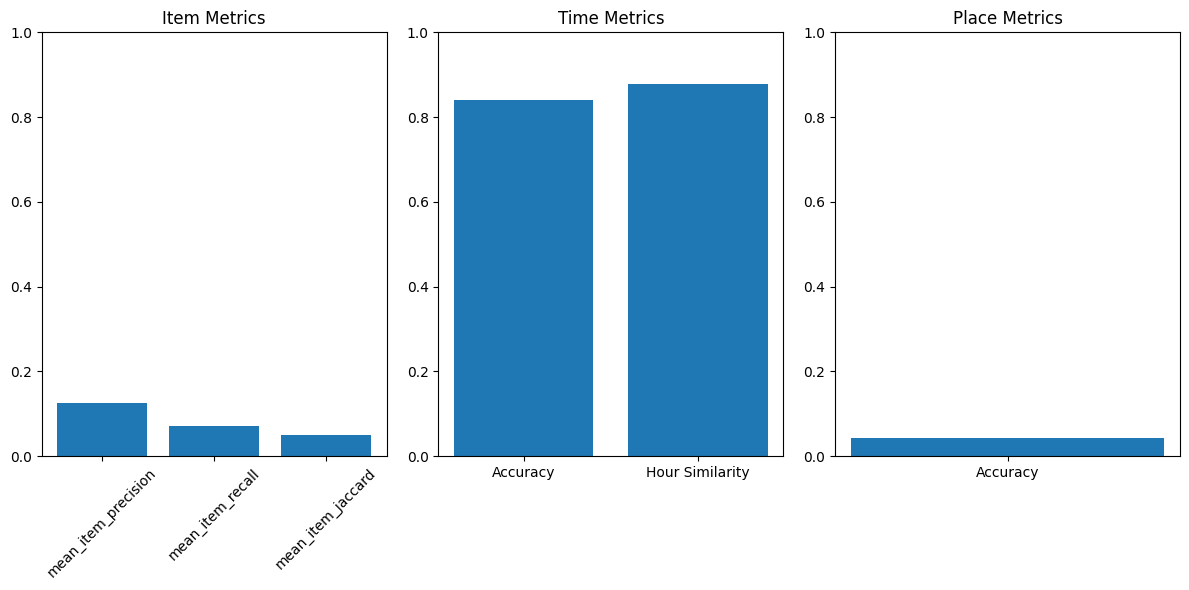


📌 Агрегированные метрики:
mean_item_precision      : 0.12553331145388907
mean_item_recall         : 0.07050063706245929
mean_item_jaccard        : 0.049991473749181614
time_accuracy            : 0.8404988513291762
mean_hour_diff           : 1.4668526419428947
place_accuracy           : 0.04332129963898917
total_users              : 6094
users_with_predictions   : 6094

💾 Результаты сохранены в файл: comparison_results_20250629_202031.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔍 Примеры сравнений (первые 5 пользователей):

Пользователь 28095:
Фактические товары: ПЭТ  1,0л  (1/80)  Полимер, Пиво  разливное  Зеленогорское  жигулевское/50л, ПЭТ  1,5л  (1/60)  Полимер, Сигареты  Русский  стиль  эталон  компакт
Предсказанные товары: ПЭТ  1,5л  (1/120)(АН), Контейнер  500  мл  РКСП  ОП  (137*132*62)  480шт, Пиво  разливное  Сладовар  пшеничное  светлое  н/ф/50л
Фактическое место: Амурская, д.16г | Предсказанное: Ачинск-4, Привокзальный 3 мкр,д.16
Фактический час: 19 | Предсказанное время: 20:00-00:00
Метрики: Precision=0.00, Recall=0.00

Пользователь 28114:
Фактические товары: Соус  сырный  40г, Пакет  фирменный  майка, Стрипсы  "Австрийские"  из  мяса  птицы  к/в, ПЭТ  1,5л  (1/60)  Полимер, Пиво  разливное  Бельгийское  светлое/50л
Предсказанные товары: Пакет  фирменный  майка  Новый  дизайн,  черный, Пакет  фирменный  майка, Пиво  разливное  Минусинское  Жигулевское  /50  л
Фактическое место: Металлургов, д. 12 | Предсказанное: Киренского, д. 67
Фактический ча

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

try:
    model_path = "/content/drive/MyDrive/Colab Notebooks/lasttestmodel.joblib"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Файл модели не найден: {model_path}")

    predictor = PurchasePredictor()
    predictor.load_model(model_path)
    print(" Модель успешно загружена")
except Exception as e:
    print(f" Ошибка загрузки модели: {e}")
    raise

try:
    json_path = "/content/ai.json"
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Файл данных не найден: {json_path}")

    with open(json_path, 'r', encoding='utf-8') as f:
        first_lines = [next(f) for _ in range(10)]
        print("Первые строки файла:")
        print(''.join(first_lines))

        f.seek(0)
        new_data = json.load(f)

    print(f" Данные успешно загружены (записей: {len(new_data)})")
except json.JSONDecodeError as je:
    print(f" Ошибка формата JSON: {je}")
    print("Проверьте, что файл содержит валидный JSON")
    raise
except Exception as e:
    print(f" Ошибка загрузки данных: {e}")
    raise

if not isinstance(new_data, list):
    print(" Ожидается список записей в JSON")
    raise ValueError("Некорректный формат данных")

print("\nПример первой записи:")
print(json.dumps(new_data[0], indent=2, ensure_ascii=False))

try:
    df_new = predictor.load_and_preprocess(new_data)
    print("\nДанные после предобработки:")
    print(f"Количество записей: {len(df_new)}")
    print(f"Колонки: {list(df_new.columns)}")
    print("\nПервые 5 записей:")
    display(df_new.head())
except Exception as e:
    print(f" Ошибка предобработки данных: {e}")
    raise

def prepare_comparison_data(predictor, df_new):
    results = []
    metrics = {
        'item_metrics': defaultdict(list),
        'time_metrics': defaultdict(list),
        'place_metrics': defaultdict(list)
    }

    actual_by_user = df_new.groupby('customerId').agg({
        'goodsName': list,
        'pointName': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
        'hour': lambda x: x.mode()[0] if len(x.mode()) > 0 else None
    }).to_dict('index')

    for user_id, user_data in actual_by_user.items():
        try:
            prediction = predictor.predict_for_customer(str(user_id))

            actual_items = set(user_data['goodsName'])
            predicted_items = set(prediction['top_items'])

            all_items = list(actual_items.union(predicted_items))
            y_true = [1 if item in actual_items else 0 for item in all_items]
            y_pred = [1 if item in predicted_items else 0 for item in all_items]

            metrics['item_metrics']['precision'].append(precision_score(y_true, y_pred, zero_division=0))
            metrics['item_metrics']['recall'].append(recall_score(y_true, y_pred, zero_division=0))
            metrics['item_metrics']['jaccard'].append(
                len(actual_items & predicted_items) / len(actual_items | predicted_items) if (actual_items | predicted_items) else 0
            )

            actual_hour = user_data['hour']
            if actual_hour is not None and prediction['predicted_time']:
                pred_hour = int(prediction['predicted_time'].split(':')[0])
                metrics['time_metrics']['hour_diff'].append(abs(actual_hour - pred_hour))
                metrics['time_metrics']['accuracy'].append(1 if abs(actual_hour - pred_hour) <= 2 else 0)

            actual_place = user_data['pointName']
            if actual_place is not None:
                metrics['place_metrics']['accuracy'].append(1 if actual_place == prediction['predicted_place'] else 0)

            results.append({
                'user_id': str(user_id),
                'actual': {
                    'items': list(actual_items),
                    'place': actual_place,
                    'hour': actual_hour
                },
                'predicted': {
                    'items': prediction['top_items'],
                    'place': prediction['predicted_place'],
                    'time_window': prediction['predicted_time']
                },
                'metrics': {
                    'item_precision': metrics['item_metrics']['precision'][-1],
                    'item_recall': metrics['item_metrics']['recall'][-1],
                    'item_jaccard': metrics['item_metrics']['jaccard'][-1],
                    'time_accuracy': metrics['time_metrics']['accuracy'][-1] if 'accuracy' in metrics['time_metrics'] else None,
                    'place_accuracy': metrics['place_metrics']['accuracy'][-1] if 'accuracy' in metrics['place_metrics'] else None
                }
            })

        except Exception as e:
            print(f"Ошибка для пользователя {user_id}: {str(e)}")

    aggregate_metrics = {
        'mean_item_precision': np.mean(metrics['item_metrics']['precision']),
        'mean_item_recall': np.mean(metrics['item_metrics']['recall']),
        'mean_item_jaccard': np.mean(metrics['item_metrics']['jaccard']),
        'time_accuracy': np.mean(metrics['time_metrics']['accuracy']) if metrics['time_metrics'].get('accuracy') else None,
        'mean_hour_diff': np.mean(metrics['time_metrics']['hour_diff']) if metrics['time_metrics'].get('hour_diff') else None,
        'place_accuracy': np.mean(metrics['place_metrics']['accuracy']) if metrics['place_metrics'].get('accuracy') else None,
        'total_users': len(results),
        'users_with_predictions': sum(1 for r in results if r['predicted']['items'])
    }

    return results, aggregate_metrics

def visualize_comparison(aggregate_metrics):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    item_metrics = ['mean_item_precision', 'mean_item_recall', 'mean_item_jaccard']
    values = [aggregate_metrics[m] for m in item_metrics]
    plt.bar(item_metrics, values)
    plt.title('Item Metrics')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 2)
    if aggregate_metrics['time_accuracy'] is not None:
        time_metrics = ['time_accuracy', 'mean_hour_diff']
        values = [aggregate_metrics['time_accuracy'], 1 - min(aggregate_metrics['mean_hour_diff']/12, 1)]
        plt.bar(['Accuracy', 'Hour Similarity'], values)
        plt.title('Time Metrics')
        plt.ylim(0, 1)

    plt.subplot(1, 3, 3)
    if aggregate_metrics['place_accuracy'] is not None:
        plt.bar(['Accuracy'], [aggregate_metrics['place_accuracy']])
        plt.title('Place Metrics')
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

print("\n Анализ предсказаний...")
comparison_results, aggregate_metrics = prepare_comparison_data(predictor, df_new)

print("\n Визуализация метрик:")
visualize_comparison(aggregate_metrics)

print("\n Агрегированные метрики:")
for metric, value in aggregate_metrics.items():
    print(f"{metric:25}: {value if value is not None else 'N/A'}")

output_filename = f"comparison_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
result_data = {
    'metadata': {
        'model_loaded': model_file,
        'data_analyzed': new_data_file,
        'analysis_date': datetime.now().isoformat(),
        'num_users': len(comparison_results)
    },
    'aggregate_metrics': aggregate_metrics,
    'user_comparisons': comparison_results
}

with open(output_filename, 'w', encoding='utf-8') as f:
    json.dump(result_data, f, ensure_ascii=False, indent=2)

print(f"\n Результаты сохранены в файл: {output_filename}")
files.download(output_filename)

print("\n Примеры сравнений (первые 5 пользователей):")
for i, res in enumerate(comparison_results[:5]):
    print(f"\nПользователь {res['user_id']}:")
    print(f"Фактические товары: {', '.join(res['actual']['items'][:5])}{'...' if len(res['actual']['items']) > 5 else ''}")
    print(f"Предсказанные товары: {', '.join(res['predicted']['items'])}")
    print(f"Фактическое место: {res['actual']['place']} | Предсказанное: {res['predicted']['place']}")
    print(f"Фактический час: {res['actual']['hour']} | Предсказанное время: {res['predicted']['time_window']}")
    print(f"Метрики: Precision={res['metrics']['item_precision']:.2f}, Recall={res['metrics']['item_recall']:.2f}")

Загружено 6094 предсказаний
Загружено 40000 реальных чеков

После предобработки: 39995 записей

Диагностика:
Уникальных пользователей в предсказаниях: 6094
Уникальных пользователей в реальных данных: 6094
Пересекающихся пользователей: 6094

Результаты анализа:
Общие пользователи: 6094
Точность (Precision): 0.125
Полнота (Recall): 0.068
F1-score: 0.088
Покрытие товаров: 6.8%
Точность времени: 21.5%
Точность места: 4.2%
Пользователи с совпадениями: 2067/6094

Топ-5 популярных товаров:
- Пакет  фирменный  майка  Новый  дизайн,  черный: 6.7%
- Пакет  фирменный  майка: 3.8%
- ПЭТ  1,5л  (1/60)  Полимер: 3.2%
- Контейнер  500  мл  РКСП  ОП  (137*132*62)  480шт: 2.4%
- Пиво  разливное  АЯН  Абаканское  светлое  /50л: 2.3%


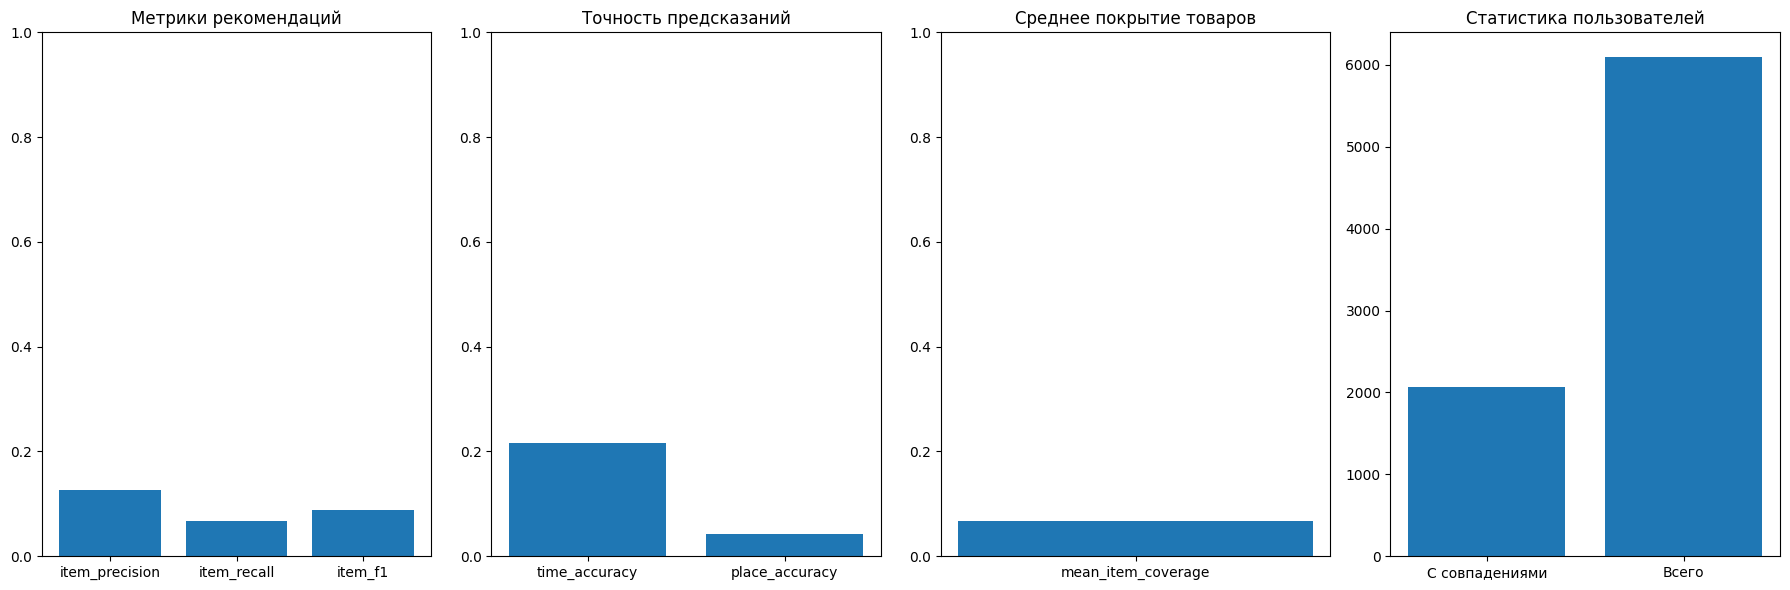


Примеры сравнений (с процентами популярности):

Лучший пример (User 1095241):
Precision: 1.00, Recall: 0.27, Coverage: 27.3%

Фактические покупки (первые 5):
- ПЭТ  1,5л  (1/104)(УУ) (1.8%)
- Пиво  разливное  Бочкарев  Чешское  светлое/50л (0.5%)
- Контейнер  500  мл  РКСП  ОП  (137*132*62)  480шт (2.4%)
- Сыр-Че  жареный  Тайский  перец  500  гр (0.1%)
- Пиво  разливное  Брюгге  н/ф  /50л (0.6%)

Рекомендованные товары:
- ПЭТ  1,5л  (1/104)(УУ) (1.8%)
- Контейнер  500  мл  РКСП  ОП  (137*132*62)  480шт (2.4%)
- Пакет  фирменный  майка  Новый  дизайн,  черный (6.7%)

Совпавшие товары:
- Контейнер  500  мл  РКСП  ОП  (137*132*62)  480шт (2.4%)
- Пакет  фирменный  майка  Новый  дизайн,  черный (6.7%)
- ПЭТ  1,5л  (1/104)(УУ) (1.8%)

Место: Улан-Удэ 1, ул. Гагарина, д. 57 / Улан-Удэ 4, ул.Смолина, д. 54
Время: 19 / 13:00-16:00

Средний пример (User 1447905):
Precision: 0.00, Recall: 0.00, Coverage: 0.0%

Фактические покупки (первые 5):
- ПЭТ  1,0л  (1/160) (0.8%)
- ПЭТ  1,5л  (1/120) (1.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
from google.colab import files
import os

def load_and_validate_data(predictions_path, actual_data_path):

    try:
        with open(predictions_path, 'r', encoding='utf-8') as f:
            predictions_dict = json.load(f)
            predictions = list(predictions_dict.values())
            print(f"Загружено {len(predictions)} предсказаний")

        with open(actual_data_path, 'r', encoding='utf-8') as f:
            actual_data = json.load(f)
            print(f"Загружено {len(actual_data)} реальных чеков")

        return predictions, actual_data

    except Exception as e:
        print(f"Ошибка загрузки данных: {str(e)}")
        raise

def preprocess_actual_data(actual_data):

    df = pd.DataFrame(actual_data)

    required_cols = ['customerId', 'goodsName', 'pointName', 'timeCheck']
    df = df.dropna(subset=required_cols)
    df = df.drop_duplicates(subset=['customerId', 'timeCheck', 'goodsName'])

    df['datetime'] = pd.to_datetime(df['timeCheck'])
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek

    df['customerId_str'] = df['customerId'].astype(str)

    return df

def calculate_metrics(predictions, actual_df):

    pred_users = {str(p['customerId']) for p in predictions}
    actual_users = set(actual_df['customerId_str'].unique())
    common_users = pred_users & actual_users

    print(f"\nДиагностика:")
    print(f"Уникальных пользователей в предсказаниях: {len(pred_users)}")
    print(f"Уникальных пользователей в реальных данных: {len(actual_users)}")
    print(f"Пересекающихся пользователей: {len(common_users)}")

    if not common_users:
        print("\nКритическая ошибка: Нет общих пользователей!")
        return [], {
            'item_precision': 0, 'item_recall': 0, 'item_f1': 0,
            'time_accuracy': 0, 'place_accuracy': 0,
            'total_users': 0, 'users_with_matches': 0,
            'common_users_count': 0,
            'mean_item_coverage': 0,
            'top_popular_items': {}
        }

    item_stats = actual_df['goodsName'].value_counts()
    total_purchases = item_stats.sum()
    item_popularity = {item: (count/total_purchases)*100 for item, count in item_stats.items()}

    actual_by_user = actual_df[actual_df['customerId_str'].isin(common_users)] \
        .groupby('customerId_str').agg({
            'goodsName': list,
            'pointName': lambda x: x.mode()[0] if not x.empty else None,
            'hour': lambda x: x.mode()[0] if not x.empty else None
        }).to_dict('index')

    results = []
    metrics = {
        'item_precision': [],
        'item_recall': [],
        'time_accuracy': [],
        'place_accuracy': []
    }

    for pred in predictions:
        user_id = str(pred['customerId'])
        if user_id not in actual_by_user:
            continue

        actual = actual_by_user[user_id]
        actual_items = set(actual['goodsName'])
        pred_items = set(pred.get('top_items', []))

        tp = len(actual_items & pred_items)
        fp = len(pred_items - actual_items)
        fn = len(actual_items - pred_items)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        metrics['item_precision'].append(precision)
        metrics['item_recall'].append(recall)

        time_accuracy = 0
        if 'predicted_time' in pred and actual['hour'] is not None:
            try:
                pred_hour = int(pred['predicted_time'].split(':')[0])
                time_accuracy = 1 if abs(actual['hour'] - pred_hour) <= 2 else 0
                metrics['time_accuracy'].append(time_accuracy)
            except:
                pass

        place_accuracy = 0
        if 'predicted_place' in pred and actual['pointName']:
            place_accuracy = 1 if pred['predicted_place'] == actual['pointName'] else 0
            metrics['place_accuracy'].append(place_accuracy)

        def format_items(items):
            return [f"{item} ({item_popularity.get(item, 0):.1f}%)" for item in items]

        results.append({
            'user_id': user_id,
            'actual_items': format_items(actual['goodsName']),
            'predicted_items': format_items(pred.get('top_items', [])),
            'matched_items': format_items(actual_items & pred_items),
            'actual_place': actual['pointName'],
            'predicted_place': pred.get('predicted_place'),
            'actual_hour': actual['hour'],
            'predicted_time': pred.get('predicted_time'),
            'precision': precision,
            'recall': recall,
            'item_coverage': tp / len(actual_items) if actual_items else 0
        })

    item_precision = np.mean(metrics['item_precision']) if metrics['item_precision'] else 0
    item_recall = np.mean(metrics['item_recall']) if metrics['item_recall'] else 0
    item_f1 = 2 * (item_precision * item_recall) / (item_precision + item_recall) if (item_precision + item_recall) > 0 else 0

    aggregate_metrics = {
        'item_precision': item_precision,
        'item_recall': item_recall,
        'item_f1': item_f1,
        'time_accuracy': np.mean(metrics['time_accuracy']) if metrics['time_accuracy'] else 0,
        'place_accuracy': np.mean(metrics['place_accuracy']) if metrics['place_accuracy'] else 0,
        'total_users': len(results),
        'users_with_matches': sum(1 for r in results if len(r['matched_items']) > 0),
        'common_users_count': len(common_users),
        'mean_item_coverage': np.mean([r['item_coverage'] for r in results]) if results else 0,
        'top_popular_items': dict(sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)[:5])
    }

    return results, aggregate_metrics

def visualize_results(metrics):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    item_metrics = ['item_precision', 'item_recall', 'item_f1']
    values = [metrics[m] for m in item_metrics]
    plt.bar(item_metrics, values)
    plt.title('Метрики рекомендаций')
    plt.ylim(0, 1)

    plt.subplot(1, 4, 2)
    accuracy_metrics = ['time_accuracy', 'place_accuracy']
    values = [metrics[m] for m in accuracy_metrics]
    plt.bar(accuracy_metrics, values)
    plt.title('Точность предсказаний')
    plt.ylim(0, 1)

    plt.subplot(1, 4, 3)
    coverage_metrics = ['mean_item_coverage']
    values = [metrics[m] for m in coverage_metrics]
    plt.bar(coverage_metrics, values)
    plt.title('Среднее покрытие товаров')
    plt.ylim(0, 1)

    plt.subplot(1, 4, 4)
    user_metrics = ['users_with_matches', 'total_users']
    values = [metrics['users_with_matches'], metrics['total_users']]
    plt.bar(['С совпадениями', 'Всего'], values)
    plt.title('Статистика пользователей')

    plt.tight_layout()
    plt.show()

def print_comparison_samples(results, item_popularity):

    if not results:
        print("Нет данных для сравнения")
        return

    samples = [
        max(results, key=lambda x: x['precision']),
        results[len(results)//2],
        min(results, key=lambda x: x['precision'])
    ]

    print("\nПримеры сравнений (с процентами популярности):")
    for i, res in enumerate(samples):
        print(f"\n{'Лучший' if i == 0 else 'Средний' if i == 1 else 'Худший'} пример (User {res['user_id']}):")
        print(f"Precision: {res['precision']:.2f}, Recall: {res['recall']:.2f}, Coverage: {res['item_coverage']:.1%}")

        print("\nФактические покупки (первые 5):")
        for item in res['actual_items'][:5]:
            print(f"- {item}")

        print("\nРекомендованные товары:")
        for item in res['predicted_items']:
            print(f"- {item}")

        print("\nСовпавшие товары:")
        print("\n".join(f"- {item}" for item in res['matched_items']) or "Нет совпадений")

        print(f"\nМесто: {res['actual_place']} / {res['predicted_place']}")
        print(f"Время: {res['actual_hour']} / {res['predicted_time']}")

def save_results(results, metrics, filename):
    """Сохранение результатов в файл"""
    result_data = {
        'metadata': {
            'created_at': datetime.now().isoformat(),
            'total_users': metrics['total_users'],
            'users_with_matches': metrics['users_with_matches'],
            'common_users_count': metrics['common_users_count']
        },
        'metrics': metrics,
        'sample_results': results[:3]
    }

    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(result_data, f, ensure_ascii=False, indent=2)

    print(f"\nРезультаты сохранены в {filename}")

def main():

    predictions_path = "/content/output.json"
    actual_data_path = "/content/ai.json"
    output_filename = f"comparison_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

    try:
        predictions, actual_data = load_and_validate_data(predictions_path, actual_data_path)

        actual_df = preprocess_actual_data(actual_data)
        print(f"\nПосле предобработки: {len(actual_df)} записей")

        results, metrics = calculate_metrics(predictions, actual_df)

        print("\nРезультаты анализа:")
        print(f"Общие пользователи: {metrics['common_users_count']}")
        print(f"Точность (Precision): {metrics['item_precision']:.3f}")
        print(f"Полнота (Recall): {metrics['item_recall']:.3f}")
        print(f"F1-score: {metrics['item_f1']:.3f}")
        print(f"Покрытие товаров: {metrics['mean_item_coverage']:.1%}")
        print(f"Точность времени: {metrics['time_accuracy']:.1%}")
        print(f"Точность места: {metrics['place_accuracy']:.1%}")
        print(f"Пользователи с совпадениями: {metrics['users_with_matches']}/{metrics['total_users']}")

        print("\nТоп-5 популярных товаров:")
        for item, percent in metrics['top_popular_items'].items():
            print(f"- {item}: {percent:.1f}%")

        visualize_results(metrics)

        print_comparison_samples(results, metrics['top_popular_items'])

        save_results(results, metrics, output_filename)

        if 'google.colab' in str(get_ipython()):
            files.download(output_filename)

    except Exception as e:
        print(f"\nОшибка в основном процессе: {str(e)}")

if __name__ == "__main__":
    main()